In [80]:
from statsmodels.tsa.api import ExponentialSmoothing as HWES
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
import pandas as pd
from typing import *
import numpy as np

### Data

In [ ]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
betas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
gammas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


### Helper Function

In [56]:
def get_initial_trend(series, uppercase_m: int) -> float:
    return sum([
        (series.iloc[i + uppercase_m] - series.iloc[i]).item() / uppercase_m
        for i in range(uppercase_m)
    ]) / uppercase_m

def get_initial_seasonality(series, uppercase_m: int) -> List:
    series = list(series.values)
    initial_season = []
    n_seasons = int(len(series) / uppercase_m)

    season_averages = [
        sum(series[uppercase_m * i:uppercase_m * i + uppercase_m]) / uppercase_m
        for i in range(n_seasons)
    ]

    initial_season.extend([
        sum([
            series[uppercase_m * j + i] - season_averages[j]
            for j in range(n_seasons)
        ]) / n_seasons
        for i in range(uppercase_m)
    ])

    return initial_season

### Init Series

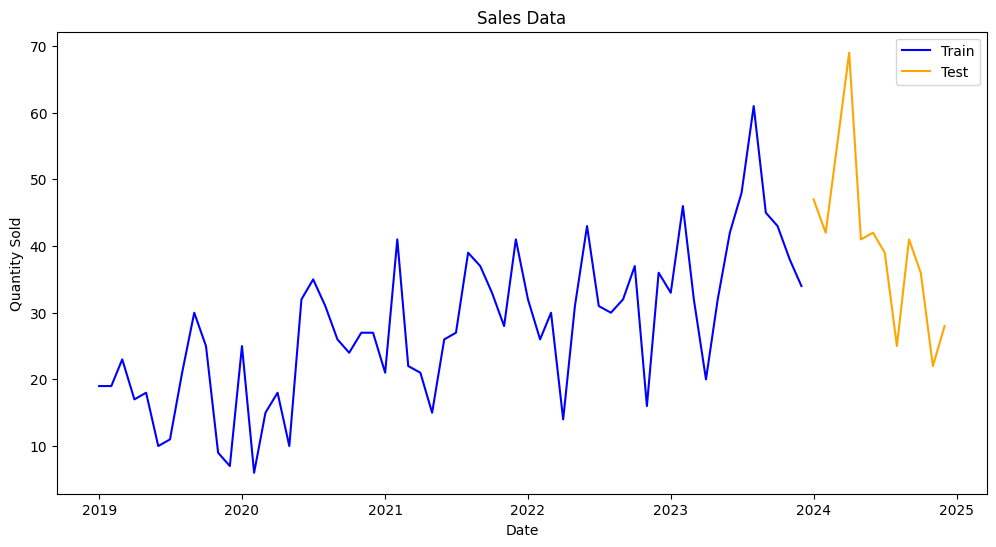

In [57]:
# create a pandas from the sales data
# the index is the date and the value is the quantity sold
original_sales = pd.read_csv("data_train/sales.csv", sep=",", header=0, index_col=0)
original_sales.index = pd.to_datetime(original_sales.index, format="%Y-%m")
original_sales = original_sales.asfreq('MS')

# # split the series into train and test sets, last 12 months are the test set
train_series = original_sales[:-12]
test_series = original_sales[-12:]

plt.figure(figsize=(12, 6))
plt.plot(train_series, label="Train", color="blue")
plt.plot(test_series, label="Test", color="orange")
plt.title("Sales Data")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.show()


### Initial Components Value

In [58]:
i_t = get_initial_trend(train_series, 12) # initial trend
i_s = get_initial_seasonality(train_series, 12) # initial seasonality

### Finding the best model without optimization

In [59]:
best_aic = float("inf") # the lowest aic is the best model
best_mape = float("inf") # the lowest mape is the best model

# get best model based on AICc and MAPE
best_model_aic = None
best_model_mape = None
  
# fit the Holt-Winters model with manual smoothing parameters
for alpha in alphas:
    for beta in betas:
        for gamma in gammas:
            try:
                forecast_model = HWES(
                    endog=train_series, 
                    seasonal_periods=12, 
                    trend='add', 
                    seasonal='add',
                    initialization_method="known",
                    initial_level=17.0,  # initial level
                    initial_trend=i_t,  # initial trend
                    initial_seasonal=i_s,  # initial seasonal
                )
                forecast_model_fit = forecast_model.fit(
                    smoothing_level=alpha,
                    smoothing_trend=beta,
                    smoothing_seasonal=gamma,
                    optimized=False,  # Disable auto-optimization
                )
                forecast = forecast_model_fit.forecast(steps=12)
                forecast.index = pd.date_range(start=test_series.index[0], periods=12, freq="MS")
                # calculate the mean absolute error percentage
                mape = mean_absolute_percentage_error(test_series, forecast)
                aic = forecast_model_fit.aic

                if aic < best_aic:
                    best_aic = aic
                    best_model_aic = forecast_model_fit
                if mape < best_mape:
                    best_mape = mape
                    best_model_mape = forecast_model_fit
            except Exception as e:
                print(f"Error: {e}")
                continue

In [ ]:
# print the best model based on AICc and MAPE
print("Best Model based on AICc: " + str(best_aic))
print(best_model_aic.summary())
print("===========================================")
# plot the best model based on AICc
plt.figure(figsize=(12, 6))
plt.plot(train_series, label="Train", color="blue")
plt.plot(test_series, label="Test", color="orange")
plt.plot(best_model_aic.fittedvalues, label="Fitted", color="green")
plt.plot(best_model_aic.forecast(steps=12), label="Forecast", color="red")
plt.axvline(x=test_series.index[0], color="red", linestyle="--", label="Train/Test Split")
plt.title("Best Model based on AICc")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.show()

In [ ]:
print("Best Model based on MAPE:" + str(best_mape))
print(best_model_mape.summary())
print("==========================================")
# plot the best model based on MAPE
plt.figure(figsize=(12, 6))
plt.plot(train_series, label="Train", color="blue")
plt.plot(test_series, label="Test", color="orange")
plt.plot(best_model_mape.fittedvalues, label="Fitted", color="green")
plt.plot(best_model_mape.forecast(steps=12), label="Forecast", color="red")
plt.axvline(x=test_series.index[0], color="red", linestyle="--", label="Train/Test Split")
plt.title("Best Model based on MAPE")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.show()

### Finding the best model with optimization

In [87]:
# tren, seasonal, damped trend,
model_combinations = [
    ("add", "add", True),
    ("add", "add", False),
    ("add", "mul", True),
    ("add", "mul", False),
    ("mul", "add", True),
    ("mul", "add", False),
    ("mul", "mul", True),
    ("mul", "mul", False),
]

i_l = 17.417  # initial level
i_t = 0.465  # initial trend
i_s = [1.09, 1.09, 1.32, 0.97, 1.03, 0.57, 0.63, 1.20, 1.72, 1.43, 0.51, 0.40]

best_aicc = float("inf") # the lowest aic is the best model
best_mape = float("inf") # the lowest mape is the best model

best_model_aicc = None
best_model_mape = None

# fit the Holt-Winters model with auto smoothing parameters
for trend, seasonal, damped_trend in model_combinations:
    try:
        forecast_model = HWES(
            endog=train_series,
            seasonal_periods=12,
            trend=trend,
            seasonal=seasonal,
            damped_trend=damped_trend,
        
        )
        forecast_model_fit = forecast_model.fit(optimized=True)
        forecast = forecast_model_fit.forecast(steps=12)
        forecast.index = pd.date_range(start=test_series.index[0], periods=12, freq="MS")
        # calculate the mean absolute error percentage
        mape = mean_absolute_percentage_error(test_series, forecast)
        aicc = forecast_model_fit.aicc

        if aicc < best_aicc:
            best_aicc = aicc
            best_model_aicc = forecast_model_fit
        if mape < best_mape:
            best_mape = mape
            best_model_mape = forecast_model_fit
    except Exception as e:
        print(f"Error: {e}")
        continue

d:\ProgrammingProject\EstateMind\estatemind-prediction-service\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Best Model based on AICc: 273.233221213167
                       ExponentialSmoothing Model Results                       
Dep. Variable:                 quantity   No. Observations:                   60
Model:             ExponentialSmoothing   SSE                           2532.214
Optimized:                         True   AIC                            256.550
Trend:                   Multiplicative   BIC                            290.060
Seasonal:                Multiplicative   AICC                           273.233
Seasonal Periods:                    12   Date:                 Sat, 12 Apr 2025
Box-Cox:                          False   Time:                         20:54:57
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level              1.4901e-08                alpha    

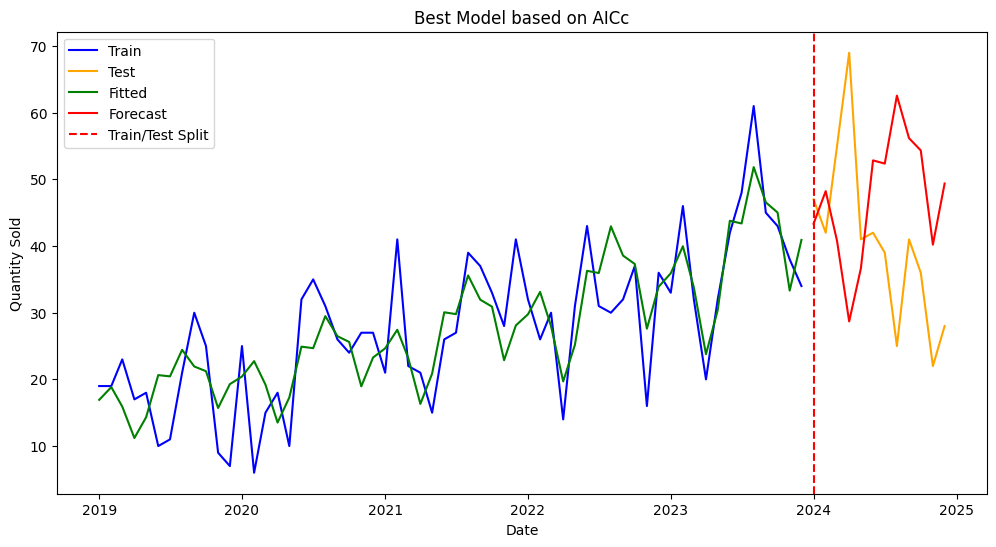

In [88]:
# Print the best model based on AICc

print("Best Model based on AICc: " + str(best_aicc))
print(best_model_aicc.summary())

print("===========================================")
# plot the best model based on AICc
plt.figure(figsize=(12, 6))
plt.plot(train_series, label="Train", color="blue")
plt.plot(test_series, label="Test", color="orange")
plt.plot(best_model_aicc.fittedvalues, label="Fitted", color="green")
plt.plot(best_model_aicc.forecast(steps=12), label="Forecast", color="red")
plt.axvline(x=test_series.index[0], color="red", linestyle="--", label="Train/Test Split")
plt.title("Best Model based on AICc")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.show()

Best Model based on MAPE: 0.33472790065610675
                       ExponentialSmoothing Model Results                       
Dep. Variable:                 quantity   No. Observations:                   60
Model:             ExponentialSmoothing   SSE                           2785.088
Optimized:                         True   AIC                            264.261
Trend:                         Additive   BIC                            299.865
Seasonal:                      Additive   AICC                           283.261
Seasonal Periods:                    12   Date:                 Sat, 12 Apr 2025
Box-Cox:                          False   Time:                         20:55:09
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level              1.3033e-06                alpha 

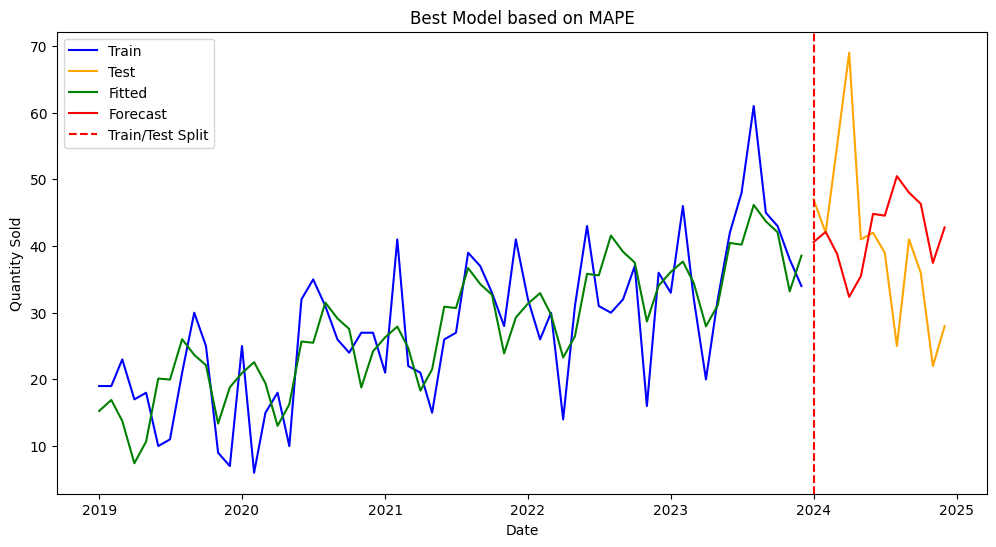

In [89]:
# Print the best model based on MAPE
print("Best Model based on MAPE: " + str(best_mape))
print(best_model_mape.summary())
print("===========================================")
# plot the best model based on MAPE
plt.figure(figsize=(12, 6))
plt.plot(train_series, label="Train", color="blue")
plt.plot(test_series, label="Test", color="orange")
plt.plot(best_model_mape.fittedvalues, label="Fitted", color="green")
plt.plot(best_model_mape.forecast(steps=12), label="Forecast", color="red")
plt.axvline(x=test_series.index[0], color="red", linestyle="--", label="Train/Test Split")
plt.title("Best Model based on MAPE")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.show()

date
2019-01-01    18.972000
2019-02-01    19.438260
2019-03-01    20.113559
2019-04-01    20.358186
2019-05-01    20.733494
2019-06-01    20.615022
2019-07-01    20.660436
2019-08-01    21.252843
2019-09-01    22.213068
2019-10-01    22.724853
2019-11-01    22.363035
2019-12-01    22.108949
2020-01-01    22.573735
2020-02-01    23.042214
2020-03-01    23.531347
2020-04-01    22.134791
2020-05-01    22.546531
2020-06-01    20.565023
2020-07-01    21.725757
2020-08-01    24.968807
2020-09-01    27.603449
2020-10-01    26.710256
2020-11-01    23.359601
2020-12-01    23.540659
2021-01-01    27.903575
2021-02-01    24.532859
2021-03-01    28.014083
2021-04-01    27.512218
2021-05-01    26.352522
2021-06-01    28.642610
2021-07-01    29.503499
2021-08-01    30.768746
2021-09-01    32.156830
2021-10-01    31.354728
2021-11-01    29.313183
2021-12-01    29.240939
2022-01-01    32.157527
2022-02-01    33.194112
2022-03-01    31.673290
2022-04-01    31.273022
2022-05-01    28.776081
2022-06-01 

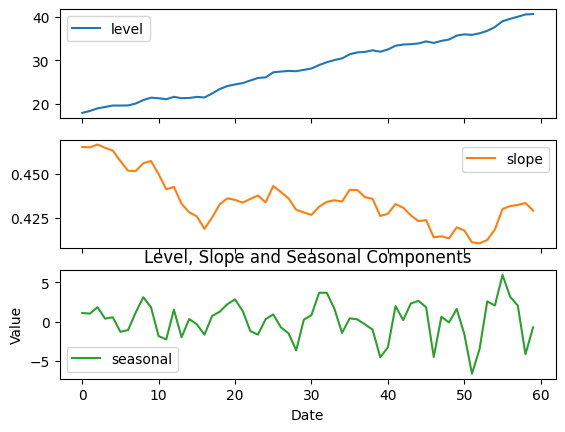

In [86]:
print(best_model_aicc.fittedvalues)

pd.DataFrame(np.c_[best_model_aicc.level, best_model_aicc.trend, best_model_aicc.season]).rename(
        columns={0: "level", 1: "slope", 2: "seasonal"}
).plot(subplots=True)

plt.title("Level, Slope and Seasonal Components")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()